# Simple HRNet
This is a light Google Colab notebook showing how to use the [simple-HRNet](https://github.com/stefanopini/simple-HRNet) repository.

It includes the conversion to TensorRT and a test of the converted model.
Please skip the section "TensorRT" if not interested.

Initial idea of running on Google Colab by @basicvisual, initial implementation by @wuyenlin (see [issue #84](https://github.com/stefanopini/simple-HRNet/issues/84)).

## Pytorch

### Clone the repo and install the dependencies

In [1]:
# clone the repo
!git clone https://github.com/stefanopini/simple-HRNet.git

Cloning into 'simple-HRNet'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 420 (delta 85), reused 73 (delta 73), pack-reused 319 (from 1)
Receiving objects: 100% (420/420), 78.05 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [2]:
%cd simple-HRNet
!pwd

/content/simple-HRNet
/content/simple-HRNet


In [3]:
# install requirements
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.6 MB/s eta 0:00:00


In [4]:
# install vlc to get video codecs
!apt install vlc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-freefont-ttf liba52-0.7.4 libaa1 libaribb24-0 libcddb2 libdca0 libdvbpsi10 libdvdnav4
  libdvdread8 libebml5 libevdev2 libfaad2 libgudev-1.0-0 libidn12 libinput-bin libinput10 libixml10
  libjansson4 libkate1 libldb2 liblirc-client0 liblmdb0 liblua5.2-0 liblzo2-2 libmad0 libmatroska7
  libmd4c0 libmpcdec6 libmpeg2-4 libmtdev1 libmtp-common libmtp-runtime libmtp9 libnfs13 libnotify4
  libopenmpt-modplug1 libplacebo192 libprotobuf-lite23 libproxy-tools libproxy1v5 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libqt5x11extras5
  libresid-builder0c2a libsdl-image1.2 libsdl1.2debian libsecret-1-0 libsecret-common libshout3
  libsidplay2 libsmbclient libspatialaudio0 libspeexdsp1 libtag1v5 libtag1v5-vanilla libtalloc2
  libtdb1 libtevent0 libudev1 libupnp13 libva-wayland2 libvlc-bin libvlc5 libvlccore9 l

### Add yolov3
Clone yolov3 for multiprocessing support. This can be skipped for single-person applications or if you plan to use YOLO v5 by Ultralytics.

In [5]:
# download git submodules
!git submodule update --init --recursive

Submodule 'models/detectors/yolo' (https://github.com/eriklindernoren/PyTorch-YOLOv3) registered for path 'models_/detectors/yolo'
Cloning into '/content/simple-HRNet/models_/detectors/yolo'...
Submodule path 'models_/detectors/yolo': checked out '47b7c912877ca69db35b8af3a38d6522681b3bb3'


In [6]:
%cd /content/simple-HRNet/models_/detectors/yolo
!pip install -q -r requirements.txt

%cd /content/simple-HRNet

/content/simple-HRNet/models_/detectors/yolo
/content/simple-HRNet


In [7]:
%cd /content/simple-HRNet/models_/detectors/yolo/weights
!sh download_weights.sh

%cd /content/simple-HRNet

/content/simple-HRNet/models_/detectors/yolo/weights
--2024-11-22 15:42:14--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  31.4MB/s    in 12s     

2024-11-22 15:42:26 (20.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-11-22 15:42:26--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  30.5MB/s    in 1.1s    

2024-11-22 15:42:27 (30.5 MB/s) - ‘yolo

### Download HRNet pre-trained weights and test video

Download any of the supported official weights listed [here](https://github.com/stefanopini/simple-HRNet/#installation-instructions).

In the following, we download the weights `pose_hrnet_w48_384x288.pth` from the official Drive link.
Download of other weights (e.g. `pose_hrnet_w32_256x192.pth`) as well as weights from private Drives is supported too.

In [8]:
!pip install --upgrade --no-cache-dir gdown

In [9]:
# download weights

# create weights folder
%cd /content/simple-HRNet
!mkdir weights
%cd /content/simple-HRNet/weights

# download weights pose_hrnet_w48_384x288.pth
!gdown 1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS

# download weights pose_hrnet_w32_256x192.pth
!gdown 1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38

# download weights pose_hrnet_w32_256x256.pth
!gdown 1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v

# # download weights from your own Google Drive
# from glob import glob
# from google.colab import drive
# drive.mount('/content/drive')
# w_list = glob("/content/drive/<your drive folder>/*.pth")
# if not w_list:
#   raise FileNotFoundError("You haven't downloaded any pre-trained weights!")

%cd /content/simple-HRNet

/content/simple-HRNet
/content/simple-HRNet/weights
Downloading...
From (original): https://drive.google.com/uc?id=1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS
From (redirected): https://drive.google.com/uc?id=1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS&confirm=t&uuid=446337b5-0ff3-4c79-897c-f642c867e8fe
To: /content/simple-HRNet/weights/pose_hrnet_w48_384x288.pth
100% 255M/255M [00:04<00:00, 51.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38
From (redirected): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38&confirm=t&uuid=9ceddcee-9623-4dc0-9266-2ac38c95bde4
To: /content/simple-HRNet/weights/pose_hrnet_w32_256x192.pth
100% 115M/115M [00:00<00:00, 123MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v
From (redirected): https://drive.google.com/uc?id=1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v&confirm=t&uuid=b9859bf6-60c0-46d1-bf7c-25b5b55079aa
To: /content/simple-HRNet/weights/pose_hrnet_w32_2

In [10]:
# download a publicly available video (or just get your own)
!wget https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/WeAreGoingOnBullrun.mp4

--2024-11-22 15:44:15--  https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/WeAreGoingOnBullrun.mp4
Resolving commondatastorage.googleapis.com (commondatastorage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to commondatastorage.googleapis.com (commondatastorage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13183260 (13M) [video/mp4]
Saving to: ‘WeAreGoingOnBullrun.mp4’

WeAreGoingOnBullrun 100%[===================>]  12.57M  --.-KB/s    in 0.1s    

2024-11-22 15:44:16 (93.5 MB/s) - ‘WeAreGoingOnBullrun.mp4’ saved [13183260/13183260]



### Test the API


In [34]:
import cv2
import requests
import matplotlib.pyplot as plt
import torch
from skimage import io
from PIL import Image
from SimpleHRNet import SimpleHRNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # singleperson, COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", multiperson=False, device=device)

# # multiperson w/ YOLOv3, COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", device=device)

# # multiperson w/ YOLOv3, COCO weights, small model
# model = SimpleHRNet(32, 17, "./weights/pose_hrnet_w32_256x192.pth", device=device)

# # multiperson w/ YOLOv3, MPII weights
# model = SimpleHRNet(32, 16, "./weights/pose_hrnet_w32_256x256.pth", device=device)

# # multiperson w/ YOLOv5 (medium), COCO weights
model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", yolo_version='v5', yolo_model_def='yolov5m', device=device)

# multiperson w/ YOLOv5 nano, COCO weights, small model
# model = SimpleHRNet(32, 17, "./weights/pose_hrnet_w32_256x192.pth", yolo_version='v5', yolo_model_def='yolov5n', device=device)

url = 'https://st2.depositphotos.com/3591429/5245/i/450/depositphotos_52451341-stock-illustration-diverse-multiethnic-people.jpg'
im = Image.open(requests.get(url, stream=True).raw)
image = io.imread(url)

joints = model.predict(image)

device: 'cuda' - 1 GPU(s) will be used


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-22 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


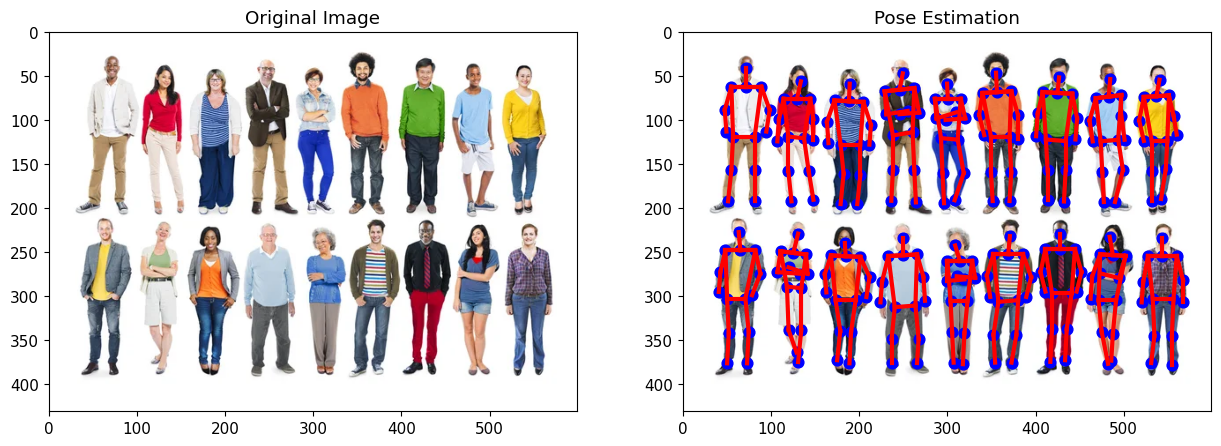

In [36]:
def plot_joints(ax, joints, dataset="coco"):
    """
    Plots joints and skeleton on the given axis for all detected people.
    Includes an additional node between left and right shoulders for each person.
    Adds edges for hands (wrists to elbows and elbows to shoulders).
    Removes blue nodes for face parts except the nose.
    """
    # Skeleton connections for COCO dataset
    skeleton = [
        [5, 6],  # Left shoulder to right shoulder
        [5, 11],  # Left shoulder to left hip
        [6, 12],  # Right shoulder to right hip
        [11, 12],  # Left hip to right hip
        [11, 13], [13, 15],  # Left leg (hip to knee, knee to ankle)
        [12, 14], [14, 16],  # Right leg (hip to knee, knee to ankle)
        [17, 0],  # Virtual midpoint to Nose
        [17, 5], [17, 6],  # Virtual midpoint to shoulders
        [5, 7], [7, 9],  # Left shoulder to left elbow, left elbow to left wrist
        [6, 8], [8, 10],  # Right shoulder to right elbow, right elbow to right wrist
    ]

    # Face-related keypoints in COCO (indices for left eye, right eye, left ear, right ear)
    face_keypoints = [1, 2, 3, 4]

    # Iterate over all detected people
    for person_idx in range(joints.shape[0]):
        person_joints = joints[person_idx]  # Extract joints for the current person

        # Calculate the midpoint between left (5) and right (6) shoulders
        left_shoulder = person_joints[5]
        right_shoulder = person_joints[6]

        if left_shoulder[2] > 0.5 and right_shoulder[2] > 0.5:
            midpoint = np.array([[
                (left_shoulder[0] + right_shoulder[0]) / 2,  # y-coordinate
                (left_shoulder[1] + right_shoulder[1]) / 2,  # x-coordinate
                min(left_shoulder[2], right_shoulder[2])     # Confidence as the minimum of both shoulders
            ]])  # Shape: (1, 3)

            # Append the midpoint as a new joint
            person_joints = np.concatenate((person_joints, midpoint), axis=0)  # Add new joint along joints axis

        # Draw the skeleton for the current person
        for bone in skeleton:
            pt1, pt2 = person_joints[bone[0]], person_joints[bone[1]]

            # Plot only if both points have confidence > 0.5
            if pt1[2] > 0.5 and pt2[2] > 0.5:
                x_vals = [pt1[1], pt2[1]]  # x-coordinates
                y_vals = [pt1[0], pt2[0]]  # y-coordinates
                ax.plot(x_vals, y_vals, linewidth=3, color='red')  # Red line for skeleton

        # Draw joints for the current person (filter out face parts except for the nose)
        for i, joint in enumerate(person_joints):
            if i in face_keypoints:
                continue  # Skip face-related keypoints other than the nose
            if joint[2] > 0.5:  # Plot joints only with confidence > 0.5
                ax.scatter(joint[1], joint[0], s=60, c='blue')  # Blue dots for joints


# Plot the image and skeleton
fig = plt.figure(figsize=(15, 8))  # Adjust figure size
ax1 = fig.add_subplot(121)
ax1.set_title("Original Image")
ax1.imshow(Image.open(requests.get(url, stream=True).raw))

ax2 = fig.add_subplot(122)
ax2.set_title("Pose Estimation")
ax2.imshow(Image.open(requests.get(url, stream=True).raw))
plot_joints(ax2, joints, dataset="coco")  # Using the COCO dataset structure
plt.show()


### Test the live script
This step can be skipped if interested in the TensorRT conversion.

In [ ]:
# # test the live script with default params (multiperson with yolo v3)
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video

# # test the live script with tiny yolo (v3)
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --use_tiny_yolo

# # test the live script with yolo v5
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --yolo_version v5

# test the live script with tiny yolo v5 (tensorrt yolo v5)
!python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --yolo_version v5 --use_tiny_yolo

Now check out the video output.avi


## TensorRT
This section install TensorRT 8.5, converts the model to TensorRT (.engine) and tests the converted model.

Tested with TensorRT 8.5.1-1+cuda11.8 and python package tensorrt 8.5.1.7 .

### Install TensorRT
A GPU is needed for this step. Please change the runtime type to "GPU".


In [ ]:
# check a GPU runtime is selected
!nvidia-smi

In [ ]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer8 python3-libnvinfer

In [ ]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

In [ ]:
# install TensorRT for python
!pip install tensorrt

In [ ]:
# clone the converion tool torch2trt
%cd /content
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt

In [ ]:
# install torch2trt
%cd /content/torch2trt
!python setup.py install

In [ ]:
%cd /content/simple-HRNet

### Export the model with tensorrt

In [ ]:
# Convert the smaller HRNet model to TensorRT - it may take a while...
!python scripts/export-tensorrt-model.py --half \
     --weights "./weights/pose_hrnet_w32_256x192.pth" --hrnet_c 32 --image_resolution '(256, 192)'

#### [Optional] Export yolov5 with TensorRT

In [ ]:
# Optional - Convert yolov5 (nano) to tensorrt too
!python /root/.cache/torch/hub/ultralytics_yolov5_master/export.py --weights yolov5n.pt --include engine --device 0 --half

### Test the tensorrt model

In [ ]:
# Run inference with the converted TensorRT model
!python scripts/live-demo.py --enable_tensorrt --filename=WeAreGoingOnBullrun.mp4 --hrnet_weights='weights/hrnet_trt.engine' \
  --hrnet_c 32 --image_resolution "(256, 192)" --yolo_version v5 --use_tiny_yolo --save_video


Now check out the video output.avi
